# Comparison of algorithms

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from crossover import *
from problems_solutions import *
from selection_algos import *
from mutations import *
from algorithms import *
from copy import deepcopy
from functools import partial
import os
from itertools import product
import json
import math
from utils import *
from sklearn.linear_model import LinearRegression
import seaborn as sns
from stats_test import *

## Loading the best configuration for SA

In [3]:
results_file = "avg_fitness_by_generation_sa.csv"

final_res = pd.read_csv(results_file)


final_res["fitness_by_gen"] = final_res["fitness_by_gen"].apply(json.loads)
final_res["final_fitness"] = final_res["fitness_by_gen"].apply(lambda x: x[-1])

final_res_sorted = final_res.sort_values(by="final_fitness", ascending=False)
final_res_sorted["best_fitness"] = final_res_sorted["best_fitness"].apply(json.loads)
final_res_sa = final_res_sorted.iloc[0]

best_config_sa = final_res_sorted.iloc[0]
best_config_sa["configuration"]



"(100, 100, 'scramble_mutation_optimized', 1.0, 10, 0.99)"

## Loading the best configuration for GA

In [4]:
results_file = "avg_fitness_by_generation.csv"

final_res = pd.read_csv(results_file)


final_res["fitness_per_generation"] = final_res["fitness_per_generation"].apply(json.loads)
final_res["final_best_fitness_prun"] = final_res["final_best_fitness_prun"].apply(json.loads)
final_res["final_fitness"] = final_res["fitness_per_generation"].apply(lambda x: x[-1])
final_res_sorted = final_res.sort_values(by="final_fitness", ascending=False)
final_res_ga = final_res_sorted.iloc[0]

best_config_ga = final_res_sorted.iloc[0]
best_config_ga["configuration"]


'swap_mutation | group_preserving_order_crossover | rank(10.0) | xo=0.8 | mut=1.0 | elitism=True'

# Loading configuration for HC

In [5]:
hc_file = "hc_results.csv"

final_res = pd.read_csv(hc_file)
final_res["fitness_hists"] = final_res["fitness_hists"].apply(json.loads)
final_res["final_fitness"] = final_res["fitness_hists"].apply(lambda x: x[-1])
final_res["fitness_scores"] = final_res["fitness_scores"].apply(json.loads)

final_res_hc = final_res.iloc[0]

## Plot fitness per generation

> Since for HC we used 6 iterations we have in the end 10_752 fitness evaluations. <br>
To plot all the fitness scores until 10_000 we will use linear regression to predict the fitness score at 10_000 fitness evaluations for hill climbing (just for plot evaluation). 

In [6]:
x = np.array([1792 * i for i in range(0, 7)]).reshape(-1, 1)
y = np.array(final_res["fitness_hists"].iloc[0])

model = LinearRegression()
model.fit(x, y)

# Predict fitness at x = 10,000
x_pred = np.array([[10_000]])
y_pred = model.predict(x_pred)

print(f"Predicted fitness at 10,000 evaluations: {y_pred[0]:.2f}")

Predicted fitness at 10,000 evaluations: 38398.02


> We can see that SA and GA overperform HC, and that HC takes much more fitness evaluations to converge. <br>
> The SA finds faster a better solution (in the first 1000 FE), as it uses in this case a scramble mutation for neighbor selection exploring the solution space faster, but from 1000 FE GA is better as it combines mutation with reproduction ensuring more diversity to find better solutions. At 10_000 FE GA finds a better solution than SA.<br>
> If the number of fitness evaluations were higher, the SA would have converged to a better solution (as the slope seems to be still positive in the last FE).

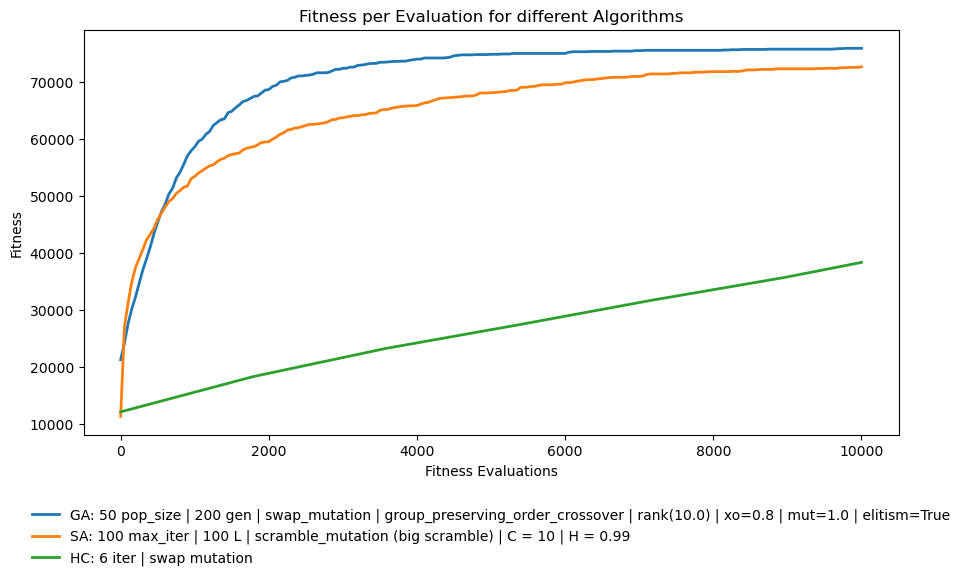

In [7]:
fitness_ga = best_config_ga["fitness_per_generation"]
fitness_sa = best_config_sa["fitness_by_gen"]
fitness_hc = final_res["fitness_hists"].iloc[0]
fitness_hc_plot = deepcopy(fitness_hc)
fitness_hc_plot[-1] = y_pred[0]

fitness_evaluations_per_iter = 50
fitness_eval_per_iter_hc = 1792

x_evals_ga = [i * fitness_evaluations_per_iter for i in range(len(fitness_ga))]
x_evals_sa = [i * fitness_evaluations_per_iter for i in range(len(fitness_sa))]
x_evals_hc = [i * fitness_eval_per_iter_hc for i in range(len(fitness_hc))]
x_evals_hc[-1] = 10_000


best_config_ga_label = f"50 pop_size | 200 gen | {best_config_ga['configuration']}"
best_config_sa_label = f"100 max_iter | 100 L | scramble_mutation (big scramble) | C = 10 | H = 0.99" 
best_config_hc_label = f"6 iter | swap mutation"  

# Plot
plt.figure(figsize=(10, 6))
plt.plot(x_evals_ga, fitness_ga, label=f"GA: {best_config_ga_label}", linewidth=2, color="tab:blue")
plt.plot(x_evals_sa, fitness_sa, label=f"SA: {best_config_sa_label}", linewidth=2, color="tab:orange")
plt.plot(x_evals_hc, fitness_hc_plot, label=f"HC: {best_config_hc_label}", linewidth=2, color="tab:green")

plt.title("Fitness per Evaluation for different Algorithms")
plt.xlabel("Fitness Evaluations")
plt.ylabel("Fitness")
plt.legend(
    loc="upper center",
    bbox_to_anchor=(0.5, -0.15),
    ncol=1,
    frameon=False
)

plt.tight_layout()
plt.show()


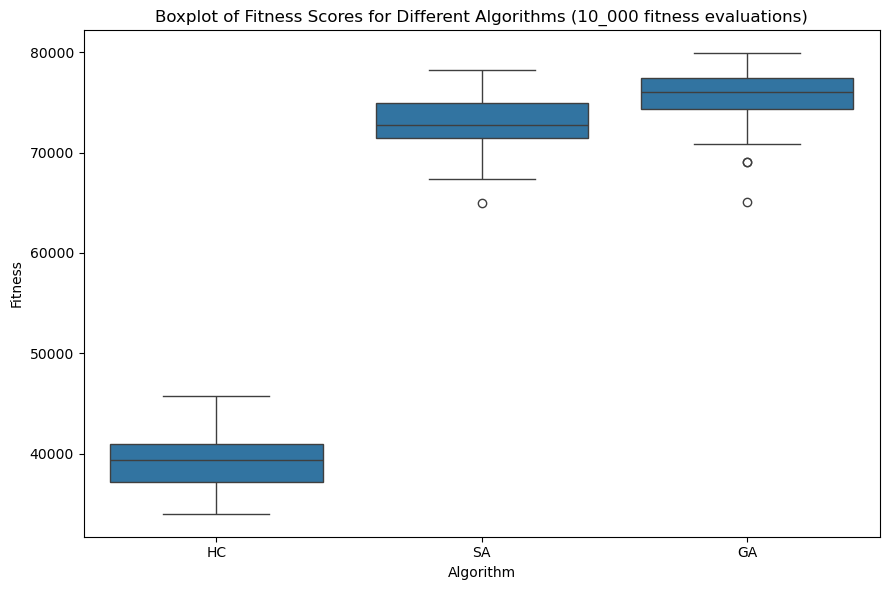

In [8]:
data = {
    "Fitness": (
        final_res_hc["fitness_scores"]
        + final_res_sa["best_fitness"]
        + final_res_ga["final_best_fitness_prun"]
    ),
    "Algorithm": (
        ["HC"] * len(final_res_hc["fitness_scores"])
        + ["SA"] * len(final_res_sa["best_fitness"])
        + ["GA"] * len(final_res_ga["final_best_fitness_prun"])
    )
}

df = pd.DataFrame(data)

plt.figure(figsize=(9, 6))
sns.boxplot(x="Algorithm", y="Fitness", data=df)
plt.title("Boxplot of Fitness Scores for Different Algorithms (10_000 fitness evaluations)")
plt.ylabel("Fitness")
plt.xlabel("Algorithm")
plt.tight_layout()
plt.show()


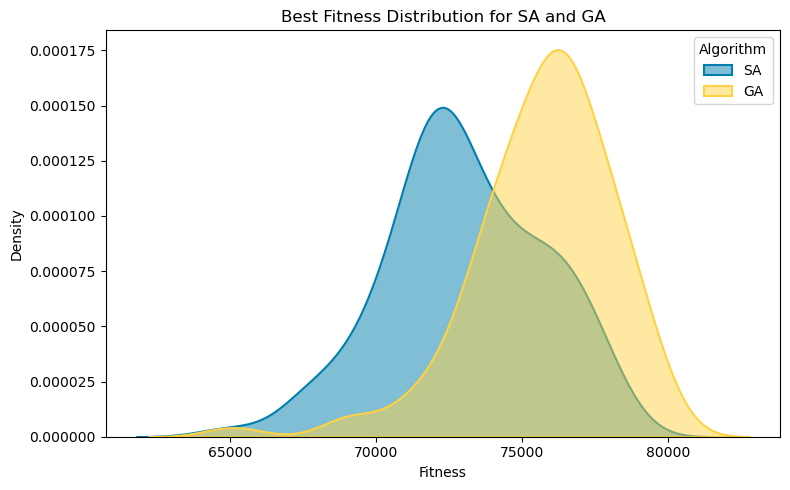

In [12]:
plot_fitness_distribution(
    df=df,
    column="Algorithm",
    palette={"SA":"#007ead","GA":"#ffd244"},
    title="Best Fitness Distribution for SA and GA",
    figsize=(8,5),
    x="Fitness"
)

> Mann Whitney U test shows that the difference in the final best fitness between GA and SA is statistally significant (p 6.5 e-12), being GA the best algorithm for this problem. 

In [9]:
sa = df[df["Algorithm"] == "SA"]["Fitness"].values
ga = df[df["Algorithm"] == "GA"]["Fitness"].values

mann_whitney_u_test(ga, sa, 0.05)

Mann-Whitney U statistic: 7811.000
P-value: 6.507e-12
----------------------------------------------------------------------------------------------------
REJECT H0: Groups differ significantly.
Rank-biserial correlation: 0.562
